In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install bs4 
from bs4 import BeautifulSoup
!pip install lxml
import requests
import ast
from datetime import datetime
import seaborn as sb

In [2]:
data = pd.read_csv('blocks.csv')
data.head()

,block_number,miner_reward,miner,coinbase_transfers,gas_used,gas_price,is_megabundle
0,13775083,125045451439363164,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,61786663982135467,1697891,73647514145,False
1,13775085,60167343345268217,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0,880215,68355280636,False
2,13775086,37221411604739120,0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB,0,523234,71137218920,False
3,13775087,26322208719570153,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0,235530,111757350314,False
4,13775088,59057993680131144,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0,952410,62009002089,False


In [3]:
data2 = pd.read_csv('arbitrages.csv')
data2.head()

,id,created_at,account_address,profit_token_address,block_number,transaction_hash,start_amount,end_amount,profit_amount
0,fae8b319-4b1c-4e31-afa1-54178051df73,2021-12-12 20:50:31.191191,0x520d18f8d73f5a6a961dc42834b9291e73731030,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12914947.0,0x1ad42324b2e62f983e639f614d6ea6d092c883fe9275...,3.105185e+18,3.121378e+18,1.619320e+16
1,1471a834-5672-459d-a34d-39c158a18a10,2021-12-12 20:50:36.550523,0x18c09bd6f4a5d72e55f332399cc2f6d1c02a7382,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,12914949.0,0x0ee3336d4afef8cff5f68d5afa135ed96f5759bf486a...,2.222100e+09,2.606449e+09,3.843492e+08
2,068613f9-ce17-4a9d-bd17-f365129ba96e,2021-12-12 20:50:36.550523,0xc8046263d5b5544f6413a98b4693488499195a46,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12914949.0,0xf57d9fd882eefc5ccdee4487b3599145d590aed03bf1...,2.870145e+18,3.261271e+18,3.911255e+17
3,cc69ec51-d46b-4daf-97cf-c3c93d101ef1,2021-12-12 20:50:37.739826,0x5e6732d6416d3f3a6574b61ef1c81316cf8d9287,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12914944.0,0x448245bf1a507b73516c4eeee01611927dada6610bf2...,1.200000e+18,1.950005e+18,7.500053e+17
4,467bdbbc-7bf2-4f96-bde6-320bfd0c89db,2021-12-12 20:50:37.739826,0x0000fee6275dab194ab538a01dd8b18b02b20000,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12914944.0,0xfcf4558f6432689ea57737fe63124a5ec39fd6ba6aaf...,7.028764e+19,1.238484e+20,5.356071e+19


In [15]:
main_dataframe = data.merge(data2, on='block_number')

In [16]:
main_dataframe.head()

,block_number,miner_reward,miner,coinbase_transfers,gas_used,gas_price,is_megabundle,id,created_at,account_address,profit_token_address,transaction_hash,start_amount,end_amount,profit_amount
0,13775083,125045451439363164,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,61786663982135467,1697891,73647514145,False,1ee23807-584c-4ea9-944c-401d32ef70ad,2021-12-13 09:58:07.032910,0x23c8030cb6e7e9f190f79591a39cc928c55d650f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x4a1b2aaa5f42570c411bd6824b29470d969423d02822...,1.061023e+18,1.097619e+18,3.659599e+16
1,13775085,60167343345268217,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0,880215,68355280636,False,063ebd73-031f-42f2-97ea-f10cede270cd,2021-12-13 04:39:12.896358,0x8fe7d9643077b4ab2885cb2dad4236cc4784413f,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdd40db0589778eb537b05d81b3eba946fb8f22f027f1...,6.764286e+16,8.050171e+16,1.285885e+16
2,13775085,60167343345268217,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0,880215,68355280636,False,4e21a4e1-5f0b-4f76-a23f-69495e31c5f7,2021-12-13 04:39:12.896358,0x5aa3393e361c2eb342408559309b3e873cd876d6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe93d0e065bbd39c887169128f9c42a534dfd8dd0d0e5...,8.307637e+17,8.517443e+17,2.098058e+16
3,13775086,37221411604739120,0x3EcEf08D0e2DaD803847E052249bb4F8bFf2D5bB,0,523234,71137218920,False,24b3109c-664b-44a5-9653-2ad97d04c564,2021-12-13 04:39:08.148976,0x000000004b614af95d1bb7c236a3aa800b722173,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xeaccb9394291d552f47332d318c6b026c7c2fce548a7...,7.475975e+17,7.657206e+17,1.812307e+16
4,13775088,59057993680131144,0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8,0,952410,62009002089,False,5a407faa-bab8-49aa-a9dd-50b6944f5ef9,2021-12-13 04:39:20.369183,0x5f62593c70069abb35dfe2b63db969e8906609d6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x7a511db7c8808997a566f57b54757b122ad346eaabc8...,2.710000e+18,2.742922e+18,3.292217e+16


In [17]:
X = main_dataframe.drop(columns=['block_number', 'miner', 'is_megabundle', 'id', 'created_at', 'account_address', 'profit_token_address', 'transaction_hash'])
Y = main_dataframe['miner_reward']
X.head()

,miner_reward,coinbase_transfers,gas_used,gas_price,start_amount,end_amount,profit_amount
0,125045451439363164,61786663982135467,1697891,73647514145,1.061023e+18,1.097619e+18,3.659599e+16
1,60167343345268217,0,880215,68355280636,6.764286e+16,8.050171e+16,1.285885e+16
2,60167343345268217,0,880215,68355280636,8.307637e+17,8.517443e+17,2.098058e+16
3,37221411604739120,0,523234,71137218920,7.475975e+17,7.657206e+17,1.812307e+16
4,59057993680131144,0,952410,62009002089,2.710000e+18,2.742922e+18,3.292217e+16


In [18]:
X = X.drop(columns=['miner_reward'])
for i in range(len(X)):
  for j in range((len(X.columns))):
    X.iloc[i,j] = float(X.iloc[i,j])

In [45]:
X = X.drop(columns=['miner_reward'])

In [20]:
for col in X.columns:
  X[col] = pd.to_numeric(X[col])
X['profit_percent'] = X['end_amount']/X['start_amount'] - 1

In [21]:
X.corr()

,miner_reward,coinbase_transfers,gas_used,gas_price,start_amount,end_amount,profit_amount,profit_percent
miner_reward,1.000000,0.967701,0.078230,0.745705,0.036587,0.036708,0.004760,0.002115
coinbase_transfers,0.967701,1.000000,0.025532,0.744217,0.033939,0.033770,0.001633,0.002945
gas_used,0.078230,0.025532,1.000000,-0.022863,-0.000242,0.000562,0.007947,-0.010137
gas_price,0.745705,0.744217,-0.022863,1.000000,0.016701,0.016685,0.001476,0.010839
start_amount,0.036587,0.033939,-0.000242,0.016701,1.000000,0.994909,0.046902,-0.000254
end_amount,0.036708,0.033770,0.000562,0.016685,0.994909,1.000000,0.147334,-0.000267
profit_amount,0.004760,0.001633,0.007947,0.001476,0.046902,0.147334,1.000000,-0.000154
profit_percent,0.002115,0.002945,-0.010137,0.010839,-0.000254,-0.000267,-0.000154,1.000000


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(max_depth=5)
k_folds = cross_val_score(decisionTree, X, Y, cv=10)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


<Figure size 1152x1080 with 0 Axes>

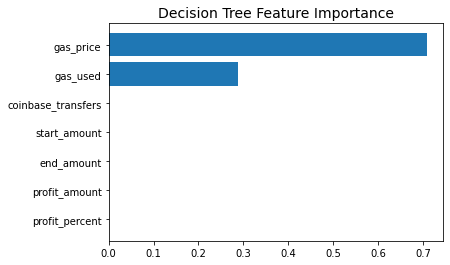

<Figure size 1152x1080 with 0 Axes>

In [47]:
decisionTree.fit(X, Y)
sorted = decisionTree.feature_importances_.argsort()
plt.barh(X.columns[sorted], decisionTree.feature_importances_[sorted])
plt.title('Decision Tree Feature Importance', fontsize=14)
plt.figure(figsize=(16,15))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
# grid search
n_estimators = [90, 150]
criterion = ['gini']
max_features = ['sqrt']
max_depth = [4,5] 
min_samples_split = [10,70]

param_grid = {'n_estimators': n_estimators,
              'criterion' : criterion,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split}

randomForest = RandomForestClassifier()
grid = GridSearchCV(estimator=randomForest, param_grid=param_grid, cv=12, verbose=4, n_jobs=4)
grid.fit(X, Y)

In [48]:
randomForest = RandomForestClassifier()
randomForest.fit(X_train, y_train)

RandomForestClassifier()

In [49]:
from sklearn import tree, metrics
from sklearn.metrics import accuracy_score
predictions = randomForest.predict(X_test)
print('Random Forest Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3))[:4] + '%')

Random Forest Accuracy: 80.2%


In [42]:
from sklearn.linear_model import LogisticRegression

In [ ]:
regularizationConstants = []
accuracies = []

for c in range(1,10,1):
  C = c/10
  logisticRegression = LogisticRegression(penalty = 'l2', C=C)
  k_folds = cross_val_score(logisticRegression, X_train, y_train, cv=2)
  regularizationConstants.append(C)
  accuracies.append(k_folds.mean())

best_C = regularizationConstants[accuracies.index(max(accuracies))]

In [ ]:
logisticRegression = LogisticRegression(penalty = 'l2', C=best_C)
logisticRegression.fit(X_train, y_train)
predictions = logisticRegression.predict(X_test)
print('Logistic Regression Accuracy: ' + str(round(100*round(metrics.accuracy_score(y_test, predictions),3),3))[:4] + '%')